<script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script> 
<script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3.0.1/es5/tex-mml-chtml.js"></script>

# Figure S7: BSK-II alone and Rabbit Serum can digest purified peptidoglycan. 
- Irnov Irnov purified the *Borrlia burgdorferi* peptidoglycan for this experiment. 
- Irnov Irnov designed and completed the original experiment. He tested many different potential media sources.
- Joshua W. McCausland wrote the code and analyzed the data. 


The outline is similar to main figure experiments. 
- Convert raw mzML files to pandas dataframes. 
- Plot the species of interest.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt,ticker
import seaborn as sns
plt.rcParams["font.family"] = "Arial" #Set global font to arial
import glob,os
import warnings
warnings.filterwarnings("ignore")

# This is a pallet of color blind friendly colors.
CB_color_cycle = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 
def y_fmt(x, y): 
    return f'{x/1e6:.1f}'.format(x).split('e')[0]

def refine_mass(df,ppm = 20,mass_to_search = 0):
    low_mass = mass_to_search - (ppm*mass_to_search/1e6)
    high_mass = mass_to_search + (ppm*mass_to_search/1e6)
    result = df.apply(lambda row: np.sum(row.peaks[np.where(np.logical_and(row.mz >= low_mass, row.mz <= high_mass))]) if row.peaks[np.where(np.logical_and(row.mz > low_mass, row.mz < high_mass))].shape[0] > 0 else 0,axis=1)
    return result 

Convert all of the mzML files to Pandas dataframes. The filenames here have a number key, so I define them here for translation. 

In [5]:
from pymzml.run import Reader
experiment_directory = f'//mothership2.stanford.edu/Data_04/Previous_memberB/Irnov Irnov/Scientist-Stanford/Data/LCMS/Data/QTOF/PolarC18/2022/20220510-PolarC18-BSKcomponent/*.mzML'
FileList = glob.glob(experiment_directory)

exp_key  = {
    1: 'BSK-Irnov',
    2: 'BSK-Zach',
    3: 'SFE-Irnov',
    4: 'BSA-CJW',
    5: 'BSA-Zach',
    6: 'RabbitSerum-CJW',
    7: 'RabbitSerum-Zach',
    8: 'Yeastolate-CJW',
    9: 'Yeastolate-Zach',
    10: 'NHS-100',
    11: 'NHS-6',
    12: 'Water',
    13: 'BSK-Irnov',
    14: 'BSK-Zach',
    15: 'SFE-Irnov',
    16: 'BSA-CJW',
    17: 'BSA-Zach',
    18: 'RabbitSerum-CJW',
    19: 'RabbitSerum-Zach',
    20: 'Yeastolate-CJW',
    21: 'Yeastolate-Zach',
    22: 'NHS-100',
    23: 'NHS-6',
    24: 'Water'
}

saving_directory = '//mothership2.stanford.edu/Common/Science communication/Manuscripts/Papers/2024/Bb PG shedding/Draft_figures/SourceData/FigS6/pickle_data'

for file in FileList:
    filename = os.path.basename(file).removesuffix('.mzML')
    if not filename.split('_')[1] == 'water':
        file_num = filename.split('_')[0]
        translation = exp_key[int(filename.split('_')[1])]
        run = Reader(file)
        run_df = pd.DataFrame({'scanID': [key for key in run.info['offset_dict'].keys() if str(key).isnumeric()]})
        run_df['time'] = run_df.scanID.apply(lambda row: run[row].scan_time_in_minutes())
        run_df['mz'] = run_df.scanID.apply(lambda row: run[row].mz)
        run_df['peaks'] = run_df.scanID.apply(lambda row: run[row].centroidedPeaks)
        run_df['peaks'] = run_df.peaks.apply(lambda row: np.column_stack(row)[1] if row.shape[0] > 0 else row)
        run_df.to_pickle(f'{saving_directory}/{file_num}_{translation}.pkl')

[]

Merge the BSk and rabbit serum dataframes, construct EICs then plot the integrated values. 

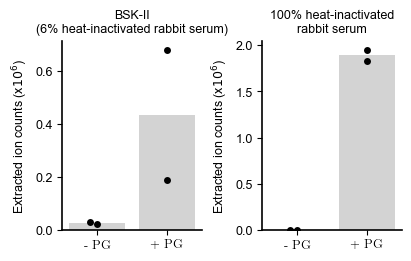

In [14]:
species_to_plot = ['Z','AEOG']
sum_windows = [[7,7.5],[1.3,2.4]]

def y_fmt(x, y): 
    return f'{x/1e6:.1f}'.format(x).split('e')[0]

def refine_mass(df,ppm = 20,mass_to_search = 0):
    low_mass = mass_to_search - (ppm*mass_to_search/1e6)
    high_mass = mass_to_search + (ppm*mass_to_search/1e6)
    result = df.apply(lambda row: np.sum(row.peaks[np.where(np.logical_and(row.mz >= low_mass, row.mz <= high_mass))]) if row.peaks[np.where(np.logical_and(row.mz > low_mass, row.mz < high_mass))].shape[0] > 0 else 0,axis=1)
    return result

reference_df = pd.read_pickle('included_small_datasets/muropeptide_reference_df.pkl').drop_duplicates()
reference_df = reference_df[reference_df.Species.isin(species_to_plot)]
#_mass = reference_df.mz_plus_1.values[0]

if 'merged_df' not in locals():
    experiment_directory = '//mothership2.stanford.edu/Common/Science communication/Manuscripts/Papers/2024/Bb PG shedding/Draft_figures/SourceData/FigS6/pickle_data'
    FileList = glob.glob(f'{experiment_directory}/*BSK*') + glob.glob(f'{experiment_directory}/*Rabbit*')
    merged_df = pd.DataFrame()
    for file in FileList:
        temp_df = pd.read_pickle(file)
        temp_df['file'] = os.path.basename(file).removesuffix('.pkl')
        merged_df = pd.concat([merged_df,temp_df])
    merged_df['media'] = merged_df.file.apply(lambda x: x.split('_')[1].split('-')[0])
    merged_df['replicate'] = merged_df.file.apply(lambda x: 2 if x.split('_')[1].split('-')[1] == 'Zach' else 1)
    merged_df['pg'] = merged_df.file.apply(lambda x: 'plus' if int(x.split('_')[0]) < 10 else 'minus')
    for _,row in reference_df.iterrows():
        merged_df[row.Species] = refine_mass(merged_df,mass_to_search=row.mz_plus_1,ppm=20)
    merged_df['media'] = merged_df.file.apply(lambda x: x.split('_')[1].split('-')[0])

for _sum_window,_species in zip(sum_windows,species_to_plot):
    df = merged_df[merged_df.time.between(_sum_window[0],_sum_window[1])].groupby(['media','pg','replicate']).sum(numeric_only=True).drop(['scanID','time'],axis=1)
df = df.reset_index()

media = ['BSK','RabbitSerum']
titles = ['BSK-II\n(6% heat-inactivated rabbit serum)','100% heat-inactivated\nrabbit serum']
fig,axs = plt.subplots(ncols = 2,figsize=[4,2.5],layout='constrained')

for _ax,grouped,_title in zip(axs,df.groupby('media'),titles):
    key,grp = grouped
    sns.barplot(data=grp,x='pg',y='AEOG',ax=_ax,color='lightgray',errcolor='gray',errwidth=1.7,errorbar=None)
    sns.swarmplot(data=grp,x='pg',y='AEOG',ax=_ax,size=5,legend=False,color= 'black')
    _ax.tick_params(axis='both',labelsize=9)
    _ax.set_title(_title,fontsize=9)
    _ax.set_ylim(bottom=0)
    _ax.set_xticklabels(['- PG','+ PG'],usetex=True)
    _ax.set_ylabel('Extracted ion counts (x$10^6$)',fontsize=9)
    _ax.set_xlabel('')
    _ax.spines[['left','bottom']].set_linewidth(1.2)
    _ax.spines[['right','top']].set_visible(False)
    _ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))